# Pairs and bot analysis

## Configurations

In [14]:
# TODO
# - Continous graph of how quality of pairs change with time
# - Divide the analysis into segments:
# 1. Configuration
# 2. Data loading
# 3. precalculation like is_paper or quote_currency, no filtration or deletion of data
# 4. Pair or bot analysis with filtration and trimming of data
# - dayily ROI

In [15]:
# imports
import pandas as pd
from datetime import timedelta
import numpy as np
from os import walk
import ast

In [16]:
# constants

SHOW_MAX_ROWS = 50
HISTORY_PATH = "../resources/history_files/"
_, _, DEALS_HISTORY_FILE_NAMES_LIST = next(walk(HISTORY_PATH))
DEALS_HISTORY_FILE_NAME = f"{len(DEALS_HISTORY_FILE_NAMES_LIST)} histories combined"
DATETIME_FORMAT='%d/%m/%Y %H:%M:%S'
QUOTE_PAIR = {"BTC"}
ALLOWED_STATUS = {"completed", "panic_sold"}
BINNING_PAIRS_STEP = timedelta(days=7)
# statistical trimming of most long and most short trades (by duration) for better averages in %
STAT_TRIM = False
TOP_TRIMMING = 0.98
BOTTOM_TRIMMING = 0.02

In [17]:
# filtration and preparation of the dataset

pd.set_option('display.max_rows', SHOW_MAX_ROWS)
pd.set_option("display.precision", 4)
COLUMNS = ["deal_id",
           "bot_id",
           "bot",
           "status",
           "pair","created_at",
           "closed_at", "duration",
           "profit_percentage_from_total_volume",
           "final_profit", "bought_volume",
          "signals", "account",
           "quote", "base", "is_paper", "owner"]

def add_owner(df, file_name):
    name = file_name.split("_")[0]
    df["owner"] = name
    return df

frames = [add_owner(pd.read_csv(HISTORY_PATH+file_name, sep=';'), file_name) for file_name in DEALS_HISTORY_FILE_NAMES_LIST]
df = pd.concat(frames)

# parsing
df = df[~df["bot_id"].isnull()]
df["bot_id"] = df["bot_id"].astype(int)
df["deal_id"] = df["deal_id"].astype(int)
df["created_at"] = pd.to_datetime(df["created_at"], format=DATETIME_FORMAT, errors='coerce')
df["closed_at"] = pd.to_datetime(df["closed_at"],  format=DATETIME_FORMAT, errors='coerce')

# adding columns
df["quote"] = df["pair"].str.split("_").str[0]
df["base"] = df["pair"].str.split("_").str[1]
df["is_paper"] = df["account"].str.startswith("Paper Account ")

unique_quote_currencies = {str(pair).split("_")[0] for pair in df["pair"].unique()}
data = {'unique bots': [len(df["bot_id"].unique())],
        'deals count' : [len(df)],
        'unique pairs' : [len(df["pair"].unique())],
        'unique quotes' : [len(unique_quote_currencies)]
        }
pd.DataFrame(unique_quote_currencies)
pd.DataFrame(data, index=["Data set preview"])

,unique bots,deals count,unique pairs,unique quotes
Data set preview,342,92915,665,5


In [18]:
QUOTE_GROUPBY_AGGREGATE = {"deal_id": "count", "pair": "nunique"}
QUOTE_GROUPBY_RENAME = {"deal_id": "deals count", "pair": "traded unique pairs"}
df.groupby(["quote"]).aggregate(QUOTE_GROUPBY_AGGREGATE).rename(columns=QUOTE_GROUPBY_RENAME)

,deals count,traded unique pairs
quote,,
AUD,5,1
BNB,180,52
BTC,1463,223
BUSD,48730,149
USDT,42537,240


In [19]:
OWNER_GROUPBY_AGGREGATE = {"deal_id": "count", "bot_id": "nunique"}
OWNER_GROUPBY_RENAME = {"deal_id": "deals count", "pair": "unique bots"}
df.groupby(["owner"]).aggregate(OWNER_GROUPBY_AGGREGATE).rename(columns=OWNER_GROUPBY_RENAME)

,deals count,bot_id
owner,,
Arun,514,9
Cosmin,19793,56
Hazhir,869,12
Nando,3807,17
Serge,23239,83
Stefan,589,1
Sunep,38470,136
Viktoria,5634,28


In [20]:
## trimm and filter
dff = df.loc[:,COLUMNS]
dff = dff[dff["status"].isin(ALLOWED_STATUS)]
if QUOTE_PAIR and len(QUOTE_PAIR) > 0:
    dff = dff[dff["quote"].isin(QUOTE_PAIR)]
# dff = dff[dff["owner"] == "Stefan"]
if STAT_TRIM:
    dff = dff[dff.duration < dff.duration.quantile(TOP_TRIMMING)]
    dff = dff[dff.duration > dff.duration.quantile(BOTTOM_TRIMMING)]
print(f"After filtrating there are {len(dff)} entries")
dff.head(3)

After filtrating there are 1148 entries


,deal_id,bot_id,bot,status,pair,created_at,closed_at,duration,profit_percentage_from_total_volume,final_profit,bought_volume,signals,account,quote,base,is_paper,owner
81,303045680,2708305,AusArun BTC Long Bot,completed,BTC_DOT,2021-02-17 22:25:47,2021-02-19 06:43:40,116273.7290,0.8476,5.6920e-05,0.0067,"[{""options"":{""time"":""3m"",""type"":""BB-20-1-LB""},...",AusArun,BTC,DOT,False,Arun
82,303046222,2708305,AusArun BTC Long Bot,completed,BTC_BQX,2021-02-17 22:26:40,2021-02-18 02:43:57,15436.8792,1.0585,3.0720e-05,0.0029,"[{""options"":{""time"":""3m"",""type"":""BB-20-1-LB""},...",AusArun,BTC,BQX,False,Arun
83,303046957,2708305,AusArun BTC Long Bot,completed,BTC_DCR,2021-02-17 22:27:39,2021-02-18 02:01:46,12846.6317,1.2627,5.5630e-05,0.0044,"[{""options"":{""time"":""3m"",""type"":""BB-20-1-LB""},...",AusArun,BTC,DCR,False,Arun


In [21]:
TIME_BIN_LABEL = "time frame"
min_created_at_date = dff["created_at"].min()
max_created_at_date = dff["created_at"].max()

created_at_bins = [min_created_at_date]
while min_created_at_date < max_created_at_date+BINNING_PAIRS_STEP:
    min_created_at_date += BINNING_PAIRS_STEP
    created_at_bins.append(min_created_at_date)
    
bin_labels = [i+1 for i in range(len(created_at_bins)-1)]
dff[TIME_BIN_LABEL] = pd.cut(dff["created_at"], bins=created_at_bins, include_lowest=True, labels=bin_labels)
#pd.qcut(dff["created_at"], q=len(created_at_bins)-1)

# Pair analysis

In [22]:
# configs
TRADES_MIN_TRESHOLD = 10 #30 # Pairs with deals count less than this number will not appear in the analysis
# labels
AVG_PROFIT_PER_DEAL_LABEL = "avg_profit_per_deal"
AVG_DURATION_LABEL = "avg_duration_of_deals"
AVG_PROFIT_PER_HOUR_LABEL = "avg_profit_per_hour"
COUNT_LABEL = "deals"
QUANTILE = 1.0 / 3

In [23]:
def transform_into_pairs_analysis_dataframe(df_input):
    DFAN_GROUPBY = [ "pair"]
    aggr = {TIME_BIN_LABEL: "first", "pair": "count", "duration": "mean", "final_profit" : "mean"}
    rename = {"duration": AVG_DURATION_LABEL, 
                "final_profit" : AVG_PROFIT_PER_DEAL_LABEL, 
                "pair": COUNT_LABEL}
    df_transform = df_input.groupby(DFAN_GROUPBY).aggregate(aggr)
    df_transform.rename(columns=rename,
               inplace=True)
    
    # filter only Pairs with decent ammount of trades
    if TRADES_MIN_TRESHOLD:
        df_transform = df_transform[df_transform[COUNT_LABEL] > TRADES_MIN_TRESHOLD]
    # create new avg_profit_per_hour column
    df_transform[AVG_PROFIT_PER_HOUR_LABEL] = df_transform[AVG_PROFIT_PER_DEAL_LABEL]/df_transform[AVG_DURATION_LABEL]*60*60
    # make duration human readable
    #df_transform[AVG_DURATION_LABEL] = df_transform[AVG_DURATION_LABEL].apply(lambda x: timedelta(seconds=x))
    df_transform[AVG_DURATION_LABEL] = df_transform[AVG_DURATION_LABEL].apply(lambda x: pd.to_timedelta(x, unit='s'))

    ## add percentiles
    # duration percentile
    dur_max = df_transform[AVG_DURATION_LABEL].max()
    dur_min = df_transform[AVG_DURATION_LABEL].min()
    dur_length = dur_max - dur_min
    def get_dur_percentile(dur):
        # 1 is highest quality, 0 lowest
        return 1 - ((dur - dur_min) / dur_length)

    df_transform["dur_percentile"] = get_dur_percentile(df_transform[AVG_DURATION_LABEL])
    
    # Profit per time percentile
    ppt_max = df_transform[AVG_PROFIT_PER_HOUR_LABEL].max()
    ppt_min = df_transform[AVG_PROFIT_PER_HOUR_LABEL].min()
    ppt_length = ppt_max - ppt_min
    def get_ppt_percentile(ppt):
        # 1 is highest quality, 0 lowest
        return (ppt - ppt_min) / ppt_length

    df_transform["ppt_percentile"] = get_ppt_percentile(df_transform[AVG_PROFIT_PER_HOUR_LABEL])
    
    ## add quality scores
    QUALITY_SCORE_LABEL = "quality score"
    df_transform[QUALITY_SCORE_LABEL] = (df_transform["ppt_percentile"] + df_transform["dur_percentile"]) / 2
    df_transform = df_transform.sort_values(by=QUALITY_SCORE_LABEL, ascending=True)
    #df_transform.sort_values(by=QUALITY_SCORE_LABEL, ascending=True).reset_index()
    return df_transform

In [24]:
# group by pair, craete  columns average duration and average profit

dfan = transform_into_pairs_analysis_dataframe(dff)
dfan

,time frame,deals,avg_duration_of_deals,avg_profit_per_deal,avg_profit_per_hour,dur_percentile,ppt_percentile,quality score
pair,,,,,,,,
BTC_SKY,1,14,5 days 01:34:11.605638,1.3144e-05,1.0812e-07,0.0000,0.0000,0.0000
BTC_RDN,4,11,4 days 03:13:40.900044,2.6983e-05,2.7193e-07,0.1877,0.0144,0.1011
BTC_PPT,4,12,3 days 23:13:43.334553,2.1400e-05,2.2472e-07,0.2213,0.0103,0.1158
BTC_AGI,5,11,3 days 01:46:26.312935,1.4454e-05,1.9592e-07,0.4016,0.0077,0.2047
BTC_AST,5,19,2 days 04:03:29.321288,3.0901e-05,5.9359e-07,0.5841,0.0428,0.3135
BTC_NAV,5,13,1 days 11:49:58.269863,3.7308e-05,1.0412e-06,0.7205,0.0823,0.4014
BTC_AMB,5,19,1 days 05:22:16.908291,2.8996e-05,9.8723e-07,0.7748,0.0775,0.4261
BTC_ATOM,1,13,1 days 03:16:33.023935,4.5056e-05,1.6519e-06,0.7924,0.1362,0.4643
BTC_COTI,5,13,0 days 23:31:01.829030,4.6651e-05,1.9837e-06,0.8239,0.1654,0.4947


In [25]:
dff[TIME_BIN_LABEL].unique()

[1, 2, 3, 4, 5]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [26]:
# bin_labels = sorted(dfan[TIME_BIN_LABEL].unique())
# an_frames = {i: transform_into_pairs_analysis_dataframe(dff[dff[TIME_BIN_LABEL] == i]) for i in bin_labels}
    
# # dfan = pd.concat(an_frames)
# unique_pairs = dff["pair"].unique()
# df_qual_progression = pd.DataFrame(index=unique_pairs)
# for tb in bin_labels:
#     df_qual_progression[tb] = np.nan
#     binned_frame = an_frames[tb]
#     #print(binned_frame)
#     for pair in unique_pairs:
#         try:
#             df_qual_progression.at[pair, tb] = binned_frame.loc[pair,QUALITY_SCORE_LABEL]
#         except KeyError:
#             pass

# pd.set_option('display.max_rows', 150)
# df_qual_progression

In [27]:
#df_qual_progression=df_qual_progression.dropna(subset=df_qual_progression.columns.values)
transposed = df_qual_progression.iloc[:].transpose()
transposed

,BTC_DOT,BTC_BQX,BTC_DCR,BTC_EGLD,BTC_ETH,BTC_ONT,BTC_GRT,BTC_POWR,BTC_POLY,BTC_ATOM,...,BTC_BZRX,BTC_UNI,BTC_NEBL,BTC_IDEX,BTC_CTSI,BTC_TRB,BTC_CTK,BTC_FLM,BTC_OST,BTC_NAS
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

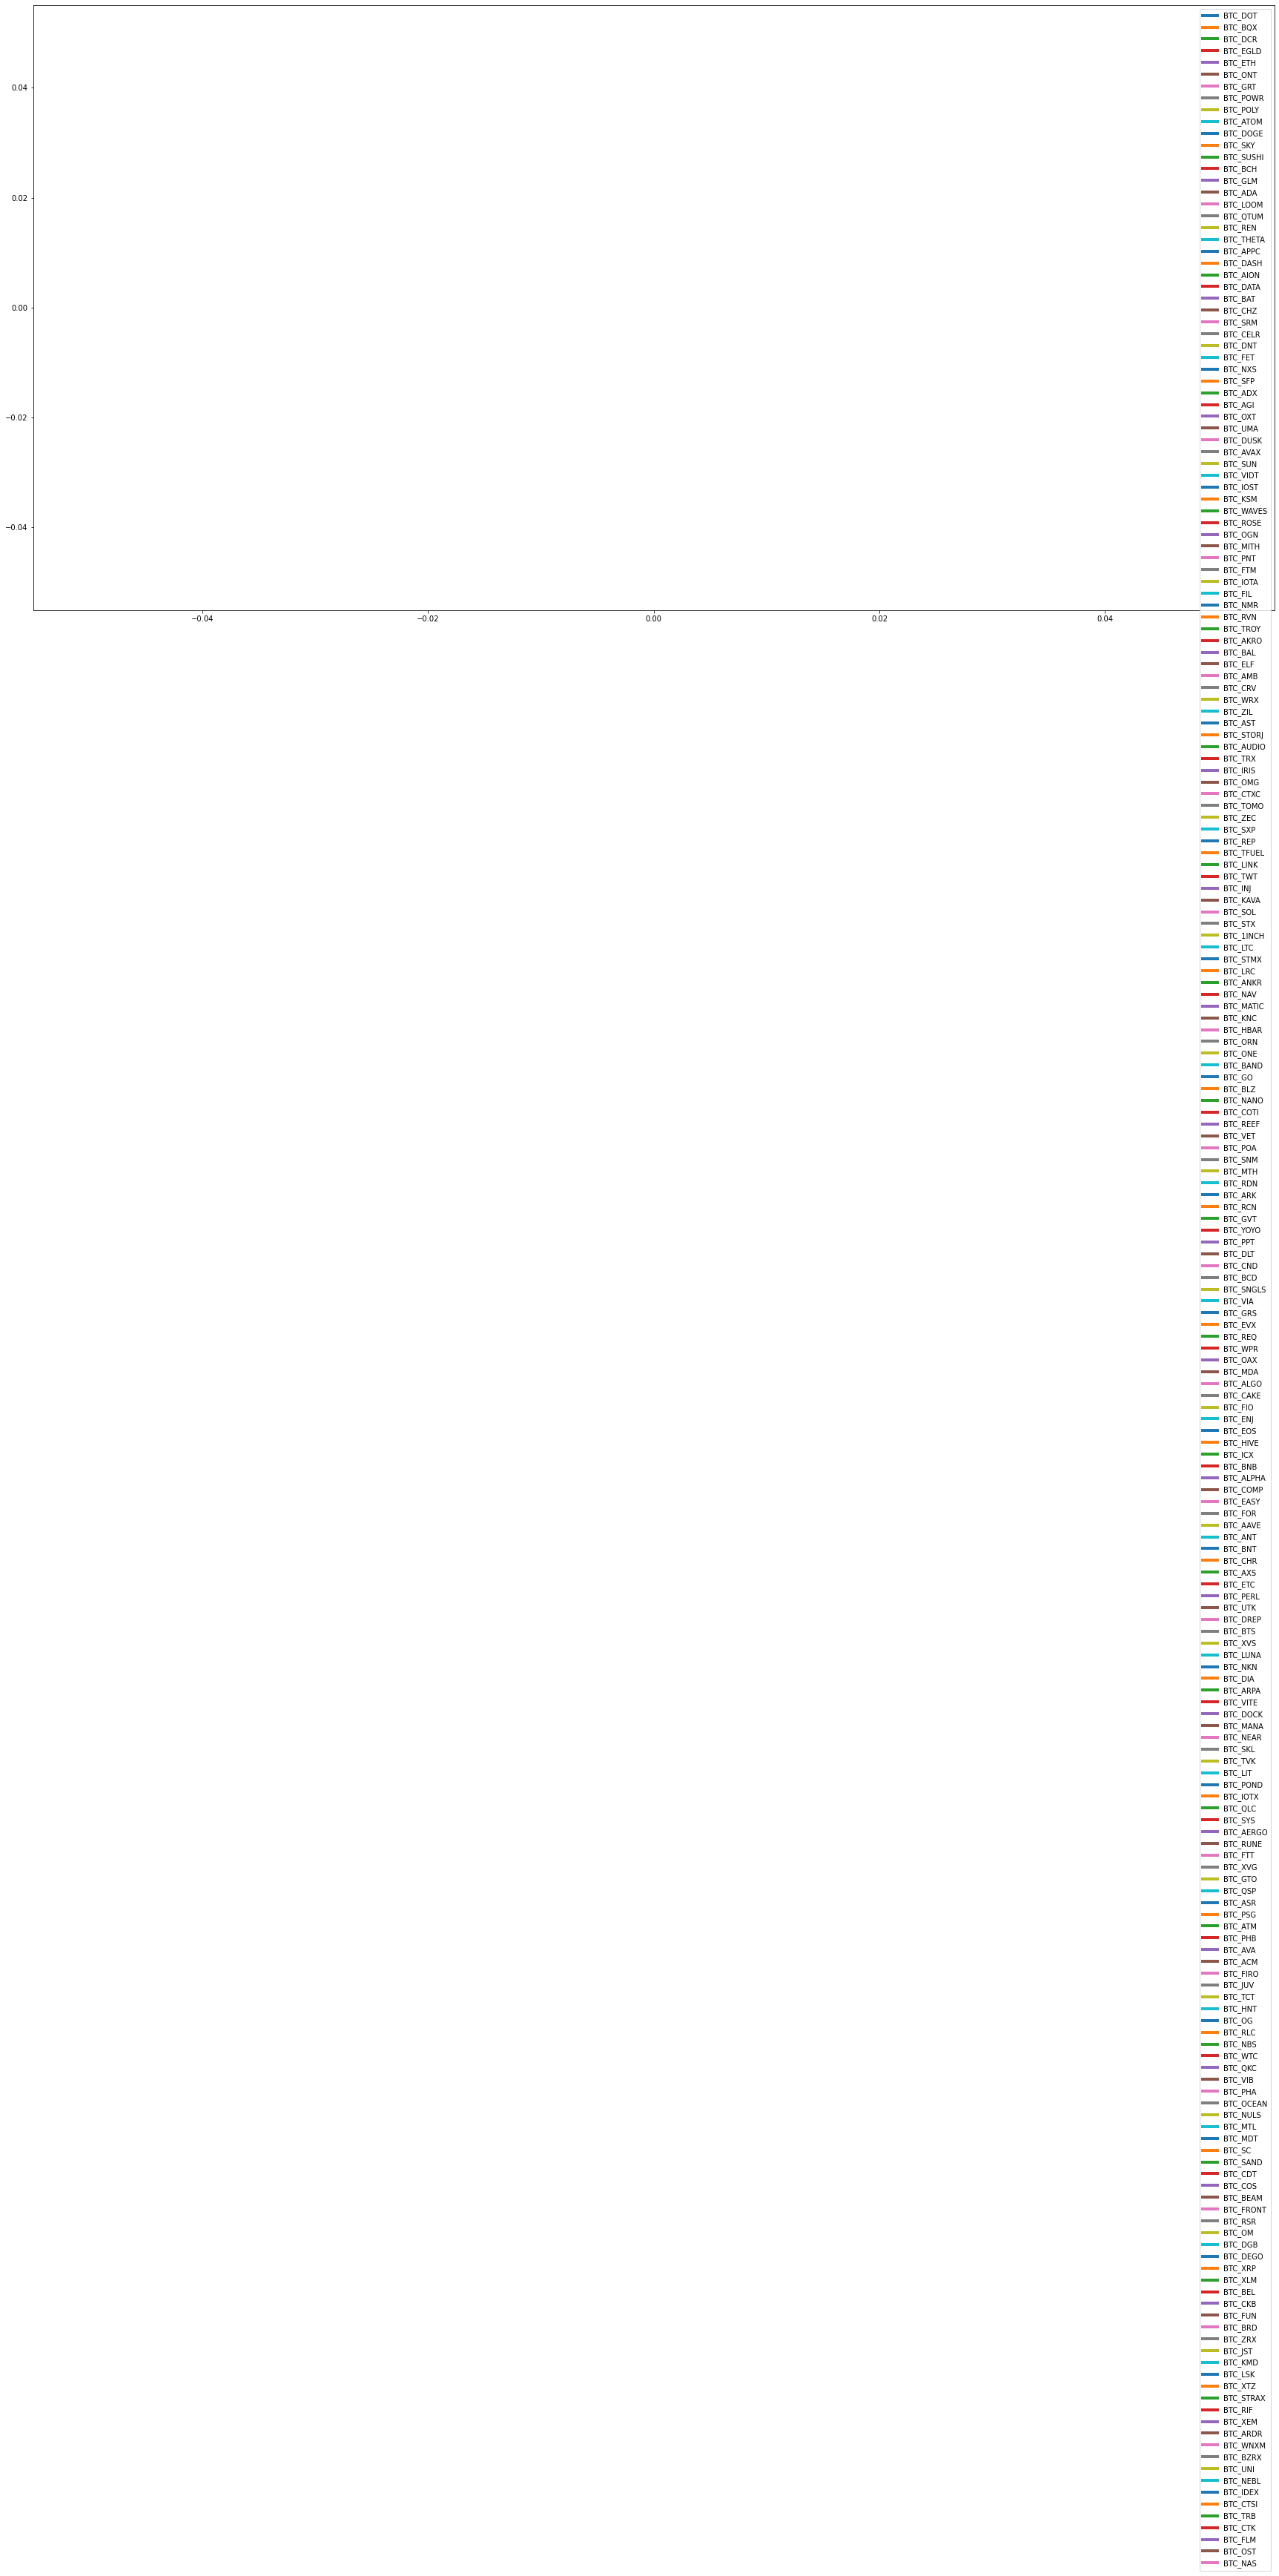

In [28]:
transposed.plot(figsize=(30,15), lw=4)

## Plots

In [29]:
#configs
plot_size = (20,5)
# plot preparations

dfplot = dfan
dfplot = dfplot.reset_index()
dfplot["pair"] = dfplot["pair"] + dfplot[COUNT_LABEL].apply(lambda c: f" ({c})")
del dfplot[COUNT_LABEL]
dfplot = dfplot.set_index("pair")

### Average Profit / h

In [30]:
#pl = dfplot.sort_values(AVG_PROFIT_PER_HOUR_LABEL)[AVG_PROFIT_PER_HOUR_LABEL].plot(kind="bar",
#                                                                            figsize=plot_size,
#                                                                           title=f'Average deal profit per hour, {DEALS_HISTORY_FILE_NAME}')
#pl.set_ylabel("profit, $")
#pl.set_xlabel(f"pair (deals count), {QUOTE_PAIR}")
#pl

### Average Duration in minutes

In [31]:
#pl = (dfplot.sort_values(by=AVG_DURATION_LABEL, ascending=False)[AVG_DURATION_LABEL].dt.total_seconds()/60).plot(kind="bar",
#                                                                                           figsize=plot_size,
#                                                                                           title=f'Average deal duration in minutes, {DEALS_HISTORY_FILE_NAME}')
#pl.set_ylabel("t, minutes")
#pl.set_xlabel(f"pair (deals count), {QUOTE_PAIR}")
#pl

## Low quality pairs

In [32]:
# configurations

In [33]:
#pl = dfan[QUALITY_SCORE_LABEL].plot(kind="bar",
#                                                                            figsize=plot_size,
#                                                                            title=f'{QUALITY_SCORE_LABEL}, {DEALS_HISTORY_FILE_NAME}')
#pl.set_ylabel("profit, $")
#pl.set_xlabel(f"pair (deals count), {QUOTE_PAIR}")
#pl

## Bot analysis

In [34]:
#configs
TIME_FRAME = "day"
SHOW_HEAD = 10
BOT_MIN_ONLINE_THRESHOLD = timedelta(days=1)
BOT_TRADES_MIN_THRESHOLD = 40
TIME_ADJUSTMENT_RATIO = {"day": 60*60*24, "hour": 60*60, "minute": 60}[TIME_FRAME]

# labels
BOT_ONLINE_LABEL = "bot online time"
PROFIT_PER_TIME_LABEL = f"gain / trading time ({TIME_FRAME})"
PROFIT_PER_TIME_LABEL_NORMALIZED = PROFIT_PER_TIME_LABEL+" (normalized by bought volume)" #normalizing
PROFIT_PER_TIME_ONLINE_LABEL = f"gain / {BOT_ONLINE_LABEL} ({TIME_FRAME})"
PROFIT_PER_TIME_ONLINE_LABEL_NORMALIZED = PROFIT_PER_TIME_ONLINE_LABEL +" (normalized by bought volume)" 
ROI_LABEL = f"ROI, % {TIME_FRAME}"

In [35]:
# analysis
df_roi_an = dff.groupby(["bot_id"]).aggregate(
    {"bot": "first",
    "is_paper": "first",
    "owner": "first",
     "quote": "first",
     "pair": "count", 
     "duration": "sum",
     "final_profit" : "sum", 
     "bought_volume": "sum",
    "created_at": "min",
    "closed_at": "max"})
# df_roi_an.rename(columns = {"duration": "duration, sum", "final_profit" : "final_profit, sum"}, inplace=True)
df_roi_an["created_at_max"] = dff.groupby(["bot_id"])["created_at"].max()

df_roi_an.rename(columns = {"bot": f"{QUOTE_PAIR} bot"}, inplace = True)
df_roi_an["duration"] = df_roi_an["duration"] / TIME_ADJUSTMENT_RATIO
df_roi_an.rename(columns={"pair": COUNT_LABEL}, inplace=True)
#df_roi_an[BOT_ONLINE_LABEL] = df_roi_an["closed_at"] - df_roi_an["created_at"]
df_roi_an[BOT_ONLINE_LABEL] = df_roi_an["created_at_max"] - df_roi_an["created_at"]
df_roi_an[PROFIT_PER_TIME_LABEL] = df_roi_an["final_profit"] / df_roi_an["duration"]
df_roi_an[PROFIT_PER_TIME_LABEL_NORMALIZED] = df_roi_an[PROFIT_PER_TIME_LABEL] / df_roi_an["bought_volume"]
df_roi_an[PROFIT_PER_TIME_ONLINE_LABEL] = df_roi_an["final_profit"] / df_roi_an[BOT_ONLINE_LABEL].dt.total_seconds() * TIME_ADJUSTMENT_RATIO
df_roi_an[PROFIT_PER_TIME_ONLINE_LABEL_NORMALIZED] = df_roi_an[PROFIT_PER_TIME_ONLINE_LABEL] / df_roi_an["bought_volume"]
del df_roi_an["created_at"]
del df_roi_an["closed_at"]
del df_roi_an["created_at_max"]
df_roi_an[ROI_LABEL] = df_roi_an["final_profit"] / (df_roi_an[BOT_ONLINE_LABEL].dt.total_seconds()/(TIME_ADJUSTMENT_RATIO)) /  df_roi_an["bought_volume"] * 100
# df_roi_an[ROI_LABEL] = df_roi_an["final_profit"] / (df_roi_an["duration"] /  df_roi_an["bought_volume"] * 100

# filters
print(f"Bot min deals threshold = {BOT_TRADES_MIN_THRESHOLD}")
df_roi_an = df_roi_an[df_roi_an[COUNT_LABEL] > BOT_TRADES_MIN_THRESHOLD]#filters
if BOT_MIN_ONLINE_THRESHOLD:
    print(f"Bot min online time threshold = {BOT_MIN_ONLINE_THRESHOLD}")
    df_roi_an = df_roi_an[df_roi_an[BOT_ONLINE_LABEL] > BOT_MIN_ONLINE_THRESHOLD]

#df_roi_an["avg_bought_volume_per_deal"] = df_roi_an["bought_volume"] / df_roi_an[COUNT_LABEL]
#df_roi_an["ROI, %"] = df_roi_an["final_profit"] / df_roi_an["bought_volume"] * 100
#df_roi_an["avg_profit"] = df_roi_an["avg_bought_volume_per_deal"] * ((100+df_roi_an["ROI, %"])/100 - 1)  
print(f"Sorted by '{PROFIT_PER_TIME_LABEL_NORMALIZED}'")
df_roi_an.sort_values(by=PROFIT_PER_TIME_LABEL_NORMALIZED, ascending=False).head(SHOW_HEAD)

Bot min deals threshold = 40
Bot min online time threshold = 1 day, 0:00:00
Sorted by 'gain / trading time (day) (normalized by bought volume)'


,{'BTC'} bot,is_paper,owner,quote,deals,duration,final_profit,bought_volume,bot online time,gain / trading time (day),gain / trading time (day) (normalized by bought volume),gain / bot online time (day),gain / bot online time (day) (normalized by bought volume),"ROI, % day"
bot_id,,,,,,,,,,,,,,
3011215,Common weekend pump bot TP20,False,Viktoria,BTC,44,105.5992,0.0009,0.0057,7 days 18:52:35,8.5399e-06,0.0015,0.0001,0.0204,2.0354
3031471,SJ MAR 2 | SPOT RSI7 3m<40 TV60 VOL50 | BO/SO ...,False,Serge,BTC,80,38.6087,0.0013,0.0524,6 days 08:54:43,3.3136e-05,0.0006,0.0002,0.0038,0.3834
3087626,BTC SPOT | TV-CUM=SB,False,Serge,BTC,51,26.2170,0.0007,0.0522,2 days 11:40:41,2.6185e-05,0.0005,0.0003,0.0053,0.5285
2947238,SJ 2 MAR | SPOT RSI7 3m<40 TV60 VOL50 | BO/SO ...,True,Serge,BTC,222,80.4787,0.0090,0.3571,4 days 18:25:29,1.1203e-04,0.0003,0.0019,0.0053,0.5296
2892252,CT BTC,False,Nando,BTC,154,103.7295,0.0142,0.4588,13 days 20:37:42,1.3642e-04,0.0003,0.0010,0.0022,0.2225
2843832,Quick setup CQS Scalping https://www.youtube.c...,True,Serge,BTC,176,115.0696,0.0069,0.5403,13 days 20:29:14,5.9718e-05,0.0001,0.0005,0.0009,0.0918


In [36]:
print(f"Sorted by '{PROFIT_PER_TIME_ONLINE_LABEL_NORMALIZED}'")
df_roi_an.sort_values(by=PROFIT_PER_TIME_ONLINE_LABEL_NORMALIZED, ascending=False).head(SHOW_HEAD)

Sorted by 'gain / bot online time (day) (normalized by bought volume)'


,{'BTC'} bot,is_paper,owner,quote,deals,duration,final_profit,bought_volume,bot online time,gain / trading time (day),gain / trading time (day) (normalized by bought volume),gain / bot online time (day),gain / bot online time (day) (normalized by bought volume),"ROI, % day"
bot_id,,,,,,,,,,,,,,
3011215,Common weekend pump bot TP20,False,Viktoria,BTC,44,105.5992,0.0009,0.0057,7 days 18:52:35,8.5399e-06,0.0015,0.0001,0.0204,2.0354
2947238,SJ 2 MAR | SPOT RSI7 3m<40 TV60 VOL50 | BO/SO ...,True,Serge,BTC,222,80.4787,0.0090,0.3571,4 days 18:25:29,1.1203e-04,0.0003,0.0019,0.0053,0.5296
3087626,BTC SPOT | TV-CUM=SB,False,Serge,BTC,51,26.2170,0.0007,0.0522,2 days 11:40:41,2.6185e-05,0.0005,0.0003,0.0053,0.5285
3031471,SJ MAR 2 | SPOT RSI7 3m<40 TV60 VOL50 | BO/SO ...,False,Serge,BTC,80,38.6087,0.0013,0.0524,6 days 08:54:43,3.3136e-05,0.0006,0.0002,0.0038,0.3834
2892252,CT BTC,False,Nando,BTC,154,103.7295,0.0142,0.4588,13 days 20:37:42,1.3642e-04,0.0003,0.0010,0.0022,0.2225
2843832,Quick setup CQS Scalping https://www.youtube.c...,True,Serge,BTC,176,115.0696,0.0069,0.5403,13 days 20:29:14,5.9718e-05,0.0001,0.0005,0.0009,0.0918


In [37]:
print(f"Sorted by '{ROI_LABEL}'")
df_roi_an.sort_values(by=ROI_LABEL, ascending=False).head(SHOW_HEAD)

Sorted by 'ROI, % day'


,{'BTC'} bot,is_paper,owner,quote,deals,duration,final_profit,bought_volume,bot online time,gain / trading time (day),gain / trading time (day) (normalized by bought volume),gain / bot online time (day),gain / bot online time (day) (normalized by bought volume),"ROI, % day"
bot_id,,,,,,,,,,,,,,
3011215,Common weekend pump bot TP20,False,Viktoria,BTC,44,105.5992,0.0009,0.0057,7 days 18:52:35,8.5399e-06,0.0015,0.0001,0.0204,2.0354
2947238,SJ 2 MAR | SPOT RSI7 3m<40 TV60 VOL50 | BO/SO ...,True,Serge,BTC,222,80.4787,0.0090,0.3571,4 days 18:25:29,1.1203e-04,0.0003,0.0019,0.0053,0.5296
3087626,BTC SPOT | TV-CUM=SB,False,Serge,BTC,51,26.2170,0.0007,0.0522,2 days 11:40:41,2.6185e-05,0.0005,0.0003,0.0053,0.5285
3031471,SJ MAR 2 | SPOT RSI7 3m<40 TV60 VOL50 | BO/SO ...,False,Serge,BTC,80,38.6087,0.0013,0.0524,6 days 08:54:43,3.3136e-05,0.0006,0.0002,0.0038,0.3834
2892252,CT BTC,False,Nando,BTC,154,103.7295,0.0142,0.4588,13 days 20:37:42,1.3642e-04,0.0003,0.0010,0.0022,0.2225
2843832,Quick setup CQS Scalping https://www.youtube.c...,True,Serge,BTC,176,115.0696,0.0069,0.5403,13 days 20:29:14,5.9718e-05,0.0001,0.0005,0.0009,0.0918


In [38]:
show_id = 3065029
BOT_SHOW_FILTER = ["bot", 
                   "account",
                   "owner",
                  "is_paper",
                  "quote",
                   "bot_id", 
                   "bot_pairs",
                   "strategy",
                   "signals", 
                   "take_profit_condition",
                  "safety_order_volume / base_order_volume",
                  "safety_order_step_percentage",
                  "take_profit_type",
                  "max_safety_orders_count",
                  "martingale_volume_coefficient",
                  "martingale_step_coefficient",
                  "safety_order_volume",
                  "safety_order_volume_type",
                  "base_order_volume",
                  "base_order_volume_type"]
print(df[df["bot_id"] == show_id].iloc[0]["bot"])
for signal in ast.literal_eval((df[df["bot_id"] == show_id].iloc[0]["signals"])):
    print(signal)
df[df["bot_id"] == show_id].iloc[0][BOT_SHOW_FILTER]

SPOT SJB BREAK 60 (15+5) V5
{'options': {'time': '1h', 'points': '50'}, 'strategy': 'rsi'}
{'options': {'time': '15m', 'type': 'buy_or_strong_buy'}, 'strategy': 'trading_view'}
{'options': {'time': '1h', 'type': 'BB-20-2-LB'}, 'strategy': 'ta_preset'}
{'options': {'time': '5m', 'type': 'buy_or_strong_buy'}, 'strategy': 'trading_view'}


bot                                                              SPOT SJB BREAK 60 (15+5) V5
account                                                                              Binance
owner                                                                                 Cosmin
is_paper                                                                               False
quote                                                                                   BUSD
bot_id                                                                               3065029
bot_pairs                                                                                146
strategy                                                                                long
signals                                    [{"options":{"time":"1h","points":"50"},"strat...
take_profit_condition                                                                      3
safety_order_volume / base_order_volume                               